# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", na_values='?')
data.head()


##### Check the percentage of missing values in the columns. Rule of thumb: If the percentage of missing values is above 60%, remove the feature.

In [ ]:
for column in data.columns:
    nan_count = data[column].isna().sum()/len(data)*100
    print("Percentage of NaN in column " + column + " is " + str(nan_count) + "\n")

Remove all rows that contain nan values, since the columns with missing values can't be imputed (no numerical values)

In [ ]:
data_before = len(data)
data = data.dropna()
data_after = len(data)
print("Removed " + str(data_before-data_after) + " rows from the " + str(data_before) + " rows")

data = data.drop(columns=["education", "fnlwgt"])
print(data)


Turn string columns into categorical data

In [ ]:
string_columns = ['workclass','marital-status','occupation','relationship','race','sex','native-country']
for col in string_columns:
    data[col] = pd.Categorical(data[col])

In [ ]:
print(data['salary'].unique())
data['salary'] = data['salary'].str.strip().str.replace(r"\.$", "", regex=True)
data['salary'] = pd.Categorical(data['salary'],categories=["<=50K", ">50K"],ordered=False)

### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable.

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf).

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec).

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# determine categorical and numerical features
numerical_ix = ['age','education-num','capital-gain','capital-loss','hours-per-week']
categorical_ix = ['workclass','marital-status','occupation','relationship','race','sex','native-country']

# Define your preprocessing steps here
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler() , numerical_ix)]


# Apply your model to feature array X and labels y
def apply_model(model, ct, X, y, feature_reduction = False):
    pipeline_pca = Pipeline(steps=[('t', ct), ('pca', PCA(n_components=60)), ('m', model)])
    pipeline_nopca = Pipeline(steps=[('t', ct) , ('m', model)])

    return evaluate_model(X, y, pipeline_nopca, pipeline_pca, feature_reduction)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline_nopca, pipeline_pca, feature_reduction=False):
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    scores_nopca = cross_val_score(pipeline_nopca, X, y, cv=cv, scoring="accuracy")
    scores_pca = cross_val_score(pipeline_pca, X, y, cv=cv, scoring="accuracy")

    #print("Mean accuracy without PCA:", scores_nopca.mean())
    #print("Mean accuracy with PCA   :", scores_pca.mean())

    y_pred = cross_val_predict(pipeline_pca, X, y, cv=cv)

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    return scores_nopca.mean(), scores_pca.mean()

### DEPRECATED METHOD AS PCA IS USED INSTEAD OF FEATURE IMPORTANCE

# def show_feature_importance(pipeline, X, y, top_n = 12):
#     model = pipeline.named_steps["m"]
#     feature_names = pipeline.named_steps["t"].get_feature_names_out()

#     importance = None

#     if hasattr(model, "feature_importances_"):
#         importance = model.feature_importances_ * 100
#     elif hasattr(model, "coef_"):
#         importance = abs(model.coef_[0])
#     else:
#         print("Using permutation importance (slower)...")
#         r = permutation_importance(pipeline, X, y, n_repeats=10, random_state=42)
#         importance = r.importances_mean

#     df = pd.DataFrame({"feature": feature_names, "importance": importance})

#     df["base_feature"] = (
#         df["feature"]
#         .str.replace(r"^cat__|^num__", "", regex=True)   # remove prefixes
#         .str.split("_").str[0]                          # keep original feature name
#     )

#     agg_df = df.groupby("base_feature")["importance"].sum().sort_values(ascending=False)

#     print("\nTop Features (aggregated):")
#     print(agg_df.head(top_n))

#     red = agg_df.head(top_n).index.to_list()

#     # --- Plot aggregated importance ---
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=agg_df.head(top_n), y=agg_df.head(top_n).index, palette="viridis")
#     plt.title(f"Aggregated Feature Importance ({type(model).__name__})")
#     plt.xlabel("Importance")
#     plt.ylabel("Feature")
#     plt.show()

#     return red

# DEPRECATED METHOD AS PCA IS USED INSTEAD OF FEATURE SELECTION

# def compare_and_plot(models, ct, X, y):
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     results = {}

#     for name, model in models.items():
#         # Full features
#         pipeline_full = Pipeline(steps=[('t', ct), ('m', model)])
#         scores_full = cross_val_score(pipeline_full, X, y, cv=cv, scoring="accuracy")

#         # Reduced features
#         reduced_features = apply_model(model, ct, X, y, feature_reduction=True)
#         X_reduced = X[reduced_features]

#         cat_selected = [c for c in reduced_features if c in categorical_ix]
#         num_selected = [c for c in reduced_features if c in numerical_ix]

#         ct_reduced = ColumnTransformer([
#             ('cat', OneHotEncoder(handle_unknown='ignore'), cat_selected),
#             ('num', MinMaxScaler(), num_selected)
#         ])
#         pipeline_reduced = Pipeline(steps=[('t', ct_reduced), ('m', model)])
#         scores_reduced = cross_val_score(pipeline_reduced, X_reduced, y, cv=cv, scoring="accuracy")

#         # Store mean difference
#         results[name] = scores_reduced.mean() - scores_full.mean()

#     # Plot differences
#     plt.figure(figsize=(8, 5))
#     plt.barh(list(results.keys()), list(results.values()), color="skyblue")
#     plt.axvline(0, color="red", linestyle="--")
#     plt.xlabel("Accuracy Difference (Reduced - Full)")
#     plt.title("Effect of Feature Reduction on Model Accuracy")
#     plt.show()

#     return results

ct = ColumnTransformer(steps)

models = {
    "LogReg": LogisticRegression(max_iter=10000),
    "SGD": SGDClassifier(loss="hinge", penalty="l2", max_iter=10000),
    "DecisionTree": tree.DecisionTreeClassifier(),
    "LinearSVC": LinearSVC()
}

results_nopca = []
results_pca = []

for model in models.values():
    y = data['salary']
    X = data.drop('salary', axis=1)

    npca, ypca = apply_model(model, ct, X, y)
    results_nopca.append(npca)
    results_pca.append(ypca)

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, results_nopca, width, label="No PCA", color="steelblue")
plt.bar(x + width/2, results_pca, width, label="With PCA", color="orange")
plt.xticks(x, list(models.keys()))
plt.ylabel("Mean CV Accuracy")
plt.title("Model Performance: With vs Without PCA")
plt.legend()
plt.show()




### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0.


In [ ]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y: np.ndarray, fraction: float) -> np.ndarray:
    copy = y.copy()
    n = len(y)

    rng = np.random.default_rng()
    flip_idx = rng.choice(n, size=int(fraction*n), replace=False)

    copy.iloc[flip_idx] = 1 - copy.iloc[flip_idx]

    return copy

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot.

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [ ]:
og_data = pd.read_csv("adult.csv", na_values='?')
data = og_data.copy()

for column in data.columns:
    nan_count = data[column].isna().sum()/len(data)*100

data_before = len(data)
data = data.dropna()
data_after = len(data)

data = data.drop(columns=['education', 'fnlwgt'])
string_columns = ['workclass','marital-status','occupation','relationship','race','sex','native-country']
for col in string_columns:
    data[col] = pd.Categorical(data[col])

data['salary'] = data['salary'].str.strip().str.replace(r"\.$", "", regex=True)
data['salary'] = data['salary'].replace({"<=50K":0, ">50K":1})

og_data = data

In [ ]:
salary = og_data['salary']

data_00 = og_data.copy()

data_01 = og_data.copy()
data_01['salary'] = pertubate(salary, 0.1)

data_02 = og_data.copy()
data_02['salary'] = pertubate(salary, 0.2)

data_03 = og_data.copy()
data_03['salary'] = pertubate(salary, 0.3)

data_04 = og_data.copy()
data_04['salary'] = pertubate(salary, 0.4)

data_05 = og_data.copy()
data_05['salary'] = pertubate(salary, 0.5)

# 4 different models
lr = LogisticRegression()
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000)
dt = tree.DecisionTreeClassifier()
svc = LinearSVC()

data = [("data_00", data_00), ("data_01", data_01), ("data_02", data_02), ("data_03" ,data_03), ("data_04", data_04), ("data_05", data_05)]
models = [lr, sgd, dt, svc]

results = {
    f"data_{i:02d}": {
        model: {"mean": None, "variance": None}
        for model in models
    }
    for i, _ in enumerate(data)
}

numerical_ix = ['age' ,'education-num','capital-gain','capital-loss','hours-per-week']
categorical_ix = ['workclass','marital-status','occupation','relationship','race','sex','native-country']

steps = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler() , numerical_ix)]

ct = ColumnTransformer(steps)

for m in models:
    for name, df in data:
        scores = []

        for r in range(0,5):
            y = df['salary']
            X = df.drop('salary', axis=1)

            _, score = apply_model(m, ct, X, y)
            scores.append(score)

        mean = np.mean(scores)
        variance = np.var(scores)

        results[name][m]["mean"] = mean
        results[name][m]["variance"] = variance



In [ ]:
data_names = ["data_00", "data_01", "data_02", "data_03", "data_04", "data_05"]
x = range(len(data_names))  # 0..5

plt.figure(figsize=(8,5))

for model in models:
    means = [results[dname][model]["mean"] for dname in data_names]
    variances = [results[dname][model]["variance"] for dname in data_names]
    std_devs = np.sqrt(variances)

    plt.plot(x, means, marker='o', label=model)
    plt.fill_between(x,
                     np.array(means) - std_devs,
                     np.array(means) + std_devs,
                     alpha=0.2)

plt.xticks(x, data_names)
plt.xlabel("Dataset")
plt.ylabel("Mean Score")
plt.title("Model Performance Across Datasets")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
records = []
for dataset, models_dict in results.items():
    for model_name, stats in models_dict.items():
        records.append({
            "Dataset": dataset,
            "Model": model_name,
            "Mean": stats["mean"],
            "Variance": stats["variance"]
        })

df = pd.DataFrame(records)

print(df)

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion.

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



This part implements four methods to find similar columns across different tables in a dataset, two for each relation: join and union. The methods are:
1. Set Containment method (JOIN): Similarity between column values of different tables. \
2. Column name method (2xUNION): Similarity between column names of different tables. Measured in two different ways: 
    - Levenshtein distance (Shows how many single-character edits are needed to change one string into another) 
    - Jaccard similarity on shingles.
3. JOSIE method (JOIN): Similarity between column values of different tables, using JOSIE. Creates posting lists and prints a top k list of similar columns (k=3).

Thresholds have been set to 0.8, to avoid too many false positives.
First, we read the datasets, and store them in a list of dataframes.

In [3]:
import tqdm
# Load the dataset

def read_csv(file_path):
    try:
        df = pd.read_csv(file_path, low_memory=False)
        return df
    except Exception:
        return pd.read_csv(file_path, delimiter='_', low_memory=False)

tables = []
for i in range(0, 19):
    ct = read_csv(f'lake33/table_{i}.csv')
    ct.name = f'table_{i}.csv'
    tables.append(ct)

We first run the methods on uncleaned data, to identify first results.

In [4]:
def set_containment(set_a, set_b):
    """ Returns the containment of setA in setB """
    if len(set_a) == 0:
        return 0
    return len(set_a.intersection(set_b)) / len(set_a)

In [5]:
# Set Containment method:
def set_containment_method(dataset):
    threshold = 0.8
    
    rows_list = []
    # Iterate through pairs of tables
    for i, df1 in enumerate(tqdm.tqdm(dataset)):
        for j, df2 in enumerate(dataset):
            if i >= j:
                continue
            # Iterate through pairs of columns of both tables:
            for colidx1, col1 in enumerate(df1.columns):
                for colidx2, col2 in enumerate(df2.columns):
                    vals1 = set(df1[col1].dropna())
                    vals2 = set(df2[col2].dropna())
                    
                    sc1 = set_containment(vals1, vals2)
                    if sc1 >= threshold:
                        dict = {}
                        dict.update({'Dataset 1': df1.name, 'Column 1': str(col1), 'Dataset 2': df2.name, 'Column 2': str(col2), 'Set Containment': sc1, 'Relation': 'JOIN'})
                        rows_list.append(dict)
                    
    result = pd.DataFrame(rows_list, columns=['Dataset 1', 'Dataset 2', 'Relation', 'Column 1', 'Column 2', 'Set Containment'])
    return result

result_sc_unclean = set_containment_method(tables)
result_sc_unclean.to_csv('outputs/set_containment_results_unclean.csv', encoding='utf-8', index=False, header=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [10:08<00:00, 32.01s/it]


Results method 1: (Runtime ~ 10 minutes)

We notice the set containment method manages to identify many similarities between tables. For instance, it correctly captures similarities between tables 1 and 2, which appear to have similar data, even when the column titles are mismatched. This is the case for many tables, where the column names are different but the values are similar. 

However, this method yields a large number of false positives as well. For example, some tables appear to contain some sort of sensor data, which may have a small range of values that can potentially overlap with some other columns that have no connection to sensors, but a wide range of values. This yields a set containment value that exceeds the threshold, but the columns are not actually similar in any meaningful way.

One method to mitigate this issue would be to consider the set containment relation in both directions, however that would significantly increase the computation time.

In [6]:
# Column name method
# Two ideas: Levenshtein distance, or Jaccard similarity on shingles.
def levenshtein(s1, s2):
    m = len(s1)
    n = len(s2)
    
    prev_row = [i for i in range(n + 1)]
    curr_row = [0] * (n + 1)
    
    for i in range(1, m + 1):
        curr_row[0] = i
        for j in range(1, n + 1):
            if s1[i - 1] == s2[j - 1]:
                curr_row[j] = prev_row[j - 1]
            else:
                curr_row[j] = min(prev_row[j - 1], prev_row[j], curr_row[j - 1]) + 1
        prev_row = curr_row.copy()
    return curr_row[n]

def jaccard_similarity(s1, s2, k=2):
    def get_shingles(s, k):
        return {s[i:i+k] for i in range(len(s) - k + 1)}
    
    shingles1 = get_shingles(s1, k)
    shingles2 = get_shingles(s2, k)
    
    intersection = len(shingles1.intersection(shingles2))
    union = len(shingles1.union(shingles2))
    
    if union == 0:
        return 0.0
    return intersection / union

def column_names(dataset):
    threshold = 0.8
    rows_list = []
    for i, df1 in enumerate(tqdm.tqdm(dataset)):
        for j, df2 in enumerate(dataset):
            if i >= j:
                continue
            for colidx1, col1 in enumerate(df1.columns):
                for colidx2, col2 in enumerate(df2.columns):
                    c1 = col1.lower()
                    c2 = col2.lower()
                    has_result = False
                    
                    dict = {'Dataset 1': df1.name, 'Column 1': str(col1), 'Dataset 2': df2.name, 'Column 2': str(col2), 'Relation': 'UNION'}
                    
                    lev_ratio = (levenshtein(col1.lower(), col2.lower())) / max(len(c1), len(c2))
                    if lev_ratio <= (1 - threshold):
                        has_result = True
                        dict.update({'Levenshtein Ratio': 1 - lev_ratio})
                    
                    for k in range(2,6):
                        sim = jaccard_similarity(c1, c2, k)
                        if sim >= threshold:
                            has_result = True
                            dict.update({f'Jaccard (k={k})': sim})
                    if has_result:
                        rows_list.append(dict)
                  
    result = pd.DataFrame(rows_list, columns=['Dataset 1', 'Dataset 2', 'Relation', 'Column 1', 'Column 2', 'Levenshtein Ratio', 'Jaccard (k=2)', 'Jaccard (k=3)', 'Jaccard (k=4)', 'Jaccard (k=5)'])
    return result

result_cn_unclean = column_names(tables)
result_cn_unclean.to_csv('outputs/column_name_results_unclean.csv', encoding='utf-8', index=False, header=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:15<00:00,  3.97s/it]


Results method 2 (methods 2.1 and 2.2): (Runtime ~ 75 seconds)

The column name method is faster, as we only analyse the column names instead of searching through the whole values. The Levenshtein distance method manages to capture similarities when the column names are very similar. The threshold has been set to 20% difference, which means that the strings can differ by at most 20% of the length of the longer string. This may exclude shorter strings that are similar, but works well for longer strings which may contain spelling mistakes or shortcuts.

The Jaccard similarity method on shingles captures similarities when column names have similar substrings. This works well for column names that differ by many characters semantically, but share common words or abbreviations.

On the other hand, if the names are completely different, both methods cannot capture any similarity between tables, leading to a large number of false negatives.

In [7]:
# JOSIE method

def josie(dataset):
    # Create posting lists
    postings = {}
    for i, df in enumerate(tqdm.tqdm(dataset)):
        for j, col in enumerate(df.columns):
            vals = set(df[col].dropna())
            for entry in vals:
                entry = str(entry)
                if entry not in postings:
                    postings[entry] = set()
                postings[entry].add((df.name, j))
                
    k = 3
    rows_list = []
    
    for i, df1 in enumerate(tqdm.tqdm(dataset)):
        for j, col1 in enumerate(df1.columns):
            vals1 = set(df1[col1].dropna())
            counter = {}
            for val in vals1:
                val = str(val)
                if val in postings:
                    for (table_id, col_id) in postings[val]:
                        if table_id == df1.name: # Do not match within the same table
                            continue
                        if (table_id, col_id) not in counter:
                            counter[(table_id, col_id)] = 0
                        counter[(table_id, col_id)] += 1
            sorted_counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)
            has_result = False
            dict = {'Dataset 1': df1.name, 'Column 1': str(col1)}
            for ((table_id, col_id), count) in sorted_counter[:(min(len(counter), k))]:
                has_result = True
                dict.update({f'Similar Column {len(dict)-1}': f'Table {table_id}, Column {col_id}, Overlap: {count}'})
            if has_result:
                rows_list.append(dict)
                
    col_names = ['Dataset 1', 'Column 1']
    for i in range(k):
        col_names.append(f'Similar Column {i+1}')
    
    result = pd.DataFrame(rows_list, columns=col_names)
    return result

result_josie_unclean = josie(tables)
result_josie_unclean.to_csv('outputs/josie_results_unclean.csv', encoding='utf-8', index=False, header=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.48it/s]


Results method 3: (Runtime ~ 8 seconds)

JOSIE does great at creating posting lists quickly, and uses them to quickly find similar columns. It is very fast and also creates a top k list of similar columns, which is useful for considering more potential matches.

However, this method only uses overlap as a metric, which is not giving very insightful information on its own. This method works best if combined with other previous approaches, which could give a better idea if two columns are actually similar or not.

-- Rest of assignment follows --

In [8]:
%pip install --quiet kshingle
%pip install --quiet datasketch

import kshingle as ks
import os
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np
from datasketch import MinHash, MinHashLSH
from collections import defaultdict
from typing import Dict, List, Set, Tuple
import re

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Discovery algorithm:
1. I scan each database with read_csv.
2. I flatten each database, convert it to one string
3. I shingle with k=8
4. I calculate the Jaccard similarity between all pairs of shingles
5. I return the list of relatedness between databases

Comments:
1. File sizes are manageable enough to directly calculate Jaccard similarity without relying on MinHash
2. Tables 10 and 11 are the same
3. For k=8, most similar tables are table_13.csv <> table_7.csv | plain_8=0.1207 | plain_containment_8 = 0.2582 | minhash_8=0.1328
4. 
table_6.csv <> table_5.csv | plain_8=0.0958 | plain_containment_8 = 0.2043 | minhash_8=0.0703
table_6.csv <> table_2.csv | plain_8=0.0858 | plain_containment_8 = 0.2544 | minhash_8=0.0859
Significant Jaccard containment scores



In [9]:
def discovery_algorithm():
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """

    base_dir = "./lake33"
    datasets = {}
    ds = {}

    if not os.path.isdir(base_dir):
        return datasets  # return empty if folder not found
    for fname in os.listdir(base_dir):
        if fname.lower().endswith(".csv"):
            fpath = os.path.join(base_dir, fname)
            try:
                df = pd.read_csv(fpath, low_memory=False)
            except Exception:
                continue
            df = df.dropna().astype(object)
            datasets[fname] = df.to_numpy().flatten()
            string = " ".join(str(x) for x in datasets[fname]).replace("\n", " ")
            # merge consecutive whitespaces (book advice)
            string = re.sub(' +', ' ', string)
            ds[fname] = string

    def jaccard_set(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        if union == 0:
            return 0.0
        return intersection / union

    def jaccard_containment(set1, set2):
        intersection = len(set1.intersection(set2))
        def jacc_c1(set1, set2):
            if len(set1) == 0:
                return 0.0
            return intersection / len(set1)
        def jacc_c2(set1, set2):
            if len(set2) == 0:
                return 0.0
            return intersection / len(set2)
        return max(jacc_c1(set1, set2), jacc_c2(set1, set2))


    # Cache shingles and MinHash per file per k to avoid recomputing
    #    ks_range = range(8, 9)  # log20 suggests 7.92 (chapter 3 rule of thumb)
    shingles_k = {fname: {} for fname in ds}
    minhash_k = {fname: {} for fname in ds}

    for fname, text in ds.items():
        for k in range(8,9):
            kshingle = set(ks.shingleset_range(text, 8, 8)) #log20
            shingles_k[fname][k] = kshingle
            mh = MinHash(num_perm=128)
            for sh in kshingle:
                try:
                    mh.update(sh.encode("utf8"))
                except Exception:
                    mh.update(str(sh).encode("utf8"))
            minhash_k[fname][k] = mh

    # Print plain Jaccard (set-based) and MinHash estimated Jaccard side by side for each k
    filenames = list(ds.keys())
    for i in range(len(filenames)):
        for j in range(i + 1, len(filenames)):
            f1 = filenames[i]
            f2 = filenames[j]
            parts = [f"{f1} <> {f2}"]
            for k in range(8, 9):
                s1 = shingles_k[f1][k]
                s2 = shingles_k[f2][k]
                plain_j = jaccard_set(s1, s2)
                try:
                    est_j = minhash_k[f1][k].jaccard(minhash_k[f2][k])
                except Exception:
                    est_j = None
                parts.append(f"plain_{k}={plain_j:.4f}")
                parts.append(f"plain_containment_{k} = {jaccard_containment(s1, s2):.4f}")
                parts.append(f"minhash_{k}={est_j if est_j is None else f'{est_j:.4f}'}")
            print(" | ".join(parts))

    return datasets


discovery_algorithm()
print()


table_11.csv <> table_13.csv | plain_8=0.0017 | plain_containment_8 = 0.0082 | minhash_8=0.0000
table_11.csv <> table_14.csv | plain_8=0.0000 | plain_containment_8 = 0.0000 | minhash_8=0.0000
table_11.csv <> table_2.csv | plain_8=0.0008 | plain_containment_8 = 0.0037 | minhash_8=0.0078
table_11.csv <> table_4.csv | plain_8=0.0002 | plain_containment_8 = 0.0004 | minhash_8=0.0000
table_11.csv <> table_5.csv | plain_8=0.0001 | plain_containment_8 = 0.0002 | minhash_8=0.0000
table_11.csv <> table_6.csv | plain_8=0.0003 | plain_containment_8 = 0.0006 | minhash_8=0.0000
table_11.csv <> table_7.csv | plain_8=0.0006 | plain_containment_8 = 0.0042 | minhash_8=0.0000
table_11.csv <> table_8.csv | plain_8=0.0000 | plain_containment_8 = 0.0003 | minhash_8=0.0000
table_11.csv <> table_9.csv | plain_8=0.0442 | plain_containment_8 = 0.0871 | minhash_8=0.0469
table_13.csv <> table_14.csv | plain_8=0.0000 | plain_containment_8 = 0.0000 | minhash_8=0.0000
table_13.csv <> table_2.csv | plain_8=0.0033 | 

Table 10 and 11 appear to be the same. We delete table 10.
(table_10.csv <> table_11.csv | plain_8=1.0000 | plain_containment_8 = 1.0000 | minhash_8=1.0000)

In [10]:
import pandas as pd
import os
import json
import numpy as np

def robust_csv_loader(base_dir="./lake33"):
    """Load CSV files with various fallback strategies for malformed data"""
    
    datasets = {}
    failed_files = []
    
    if not os.path.isdir(base_dir):
        return datasets, failed_files
        
    for fname in os.listdir(base_dir):
        if fname.lower().endswith(".csv"):
            fpath = os.path.join(base_dir, fname)
            
            df = None
            load_method = None
            
            # Try multiple loading strategies
            strategies = [
                ('standard', lambda: pd.read_csv(fpath, low_memory=False)),
                ('skip_bad_lines', lambda: pd.read_csv(fpath, low_memory=False, on_bad_lines='skip')),
                ('semicolon_sep', lambda: pd.read_csv(fpath, sep=';', low_memory=False)),
                ('tab_sep', lambda: pd.read_csv(fpath, sep='\t', low_memory=False)),
                ('pipe_sep', lambda: pd.read_csv(fpath, sep='|', low_memory=False)),
                ('raw_lines', lambda: pd.read_csv(fpath, sep='\n', header=None, names=['raw_data']))
            ]
            
            for method_name, loader in strategies:
                try:
                    df = loader()
                    load_method = method_name
                    break
                except:
                    continue
            
            if df is not None:
                datasets[fname] = {'dataframe': df, 'load_method': load_method}
            else:
                failed_files.append(fname)
    
    return datasets, failed_files

def safe_json_convert(obj):
    """Convert objects to JSON-serializable format"""
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif pd.isna(obj):
        return None
    elif hasattr(obj, 'dtype'):
        return str(obj)
    else:
        return str(obj)

def generate_comprehensive_report(datasets, failed_files, output_file="data_quality_report.json"):
    """Generate comprehensive report and save to file"""
    
    report = {
        'summary': {
            'total_files_attempted': len(datasets) + len(failed_files),
            'successfully_loaded': len(datasets),
            'failed_to_load': len(failed_files),
            'failed_files': failed_files
        },
        'file_details': {}
    }
    
    for filename, data_info in datasets.items():
        df = data_info['dataframe']
        method = data_info['load_method']
        
        file_report = {
            'load_method': method,
            'shape': [int(df.shape[0]), int(df.shape[1])],
            'issues': []
        }
        
        if method in ['standard', 'semicolon_sep', 'tab_sep', 'pipe_sep', 'skip_bad_lines']:
            # Normal DataFrame analysis
            total_nulls = df.isnull().sum().sum()
            null_percentage = (total_nulls / df.size * 100) if df.size > 0 else 0
            
            # Convert data types to JSON-serializable format
            data_types = {}
            for dtype, count in df.dtypes.value_counts().items():
                data_types[str(dtype)] = int(count)
            
            file_report.update({
                'columns': [str(col) for col in df.columns],
                'data_types': data_types,
                'total_nulls': int(total_nulls),
                'null_percentage': float(round(null_percentage, 2)),
                'duplicate_rows': int(df.duplicated().sum()),
                'potential_id_columns': []
            })
            
            # Find potential ID columns
            for col in df.columns:
                if len(df) > 0:
                    try:
                        uniqueness = df[col].nunique() / len(df)
                        if uniqueness > 0.95:
                            file_report['potential_id_columns'].append(str(col))
                    except:
                        pass
            
            # Check for suspicious patterns
            suspicious_patterns = []
            for col in df.select_dtypes(include=['object']).columns:
                try:
                    suspicious_count = df[col].astype(str).str.contains(
                        r'error|null|#N/A|test|dummy|placeholder|nan', 
                        case=False, na=False
                    ).sum()
                    if suspicious_count > df.shape[0] * 0.01:
                        suspicious_patterns.append({
                            'column': str(col),
                            'count': int(suspicious_count),
                            'percentage': float(round((suspicious_count / len(df)) * 100, 2))
                        })
                except:
                    pass
            
            file_report['suspicious_patterns'] = suspicious_patterns
            
            # Add issues based on findings
            if method == 'skip_bad_lines':
                file_report['issues'].append('Some lines were skipped due to parsing errors')
            if null_percentage > 50:
                file_report['issues'].append(f'High missing data: {null_percentage:.1f}%')
            if df.duplicated().sum() > df.shape[0] * 0.1:
                file_report['issues'].append('High duplicate rate')
            if suspicious_patterns:
                file_report['issues'].append(f'Suspicious patterns found in {len(suspicious_patterns)} columns')
                
        elif method == 'raw_lines':
            file_report['issues'].append('File loaded as single column - needs manual parsing')
            # Get sample content safely
            sample_content = []
            for val in df.head(3)['raw_data']:
                sample_content.append(str(val)[:100])  # Truncate long lines
            file_report['sample_content'] = sample_content
        
        report['file_details'][filename] = file_report
    
    # Save to file with safe JSON conversion
    try:
        with open(output_file, 'w') as f:
            json.dump(report, f, indent=2, default=safe_json_convert)
    except Exception as e:
        print(f"Error saving JSON: {e}")
        # Fallback: save as text
        with open(output_file.replace('.json', '.txt'), 'w') as f:
            f.write(str(report))
        print(f"Report saved as text file instead: {output_file.replace('.json', '.txt')}")
    
    return report

def print_summary(report):
    """Print only key summary information"""
    
    print("DATA QUALITY SUMMARY")
    print("-" * 40)
    print(f"Total files: {report['summary']['total_files_attempted']}")
    print(f"Successfully loaded: {report['summary']['successfully_loaded']}")
    print(f"Failed to load: {report['summary']['failed_to_load']}")
    
    if report['summary']['failed_files']:
        print(f"Failed files: {report['summary']['failed_files']}")
    
    # Count files with issues
    files_with_issues = 0
    critical_issues = 0
    
    for filename, details in report['file_details'].items():
        if details['issues']:
            files_with_issues += 1
        if details['load_method'] in ['raw_lines', 'skip_bad_lines']:
            critical_issues += 1
    
    print(f"Files with quality issues: {files_with_issues}")
    print(f"Files with critical parsing issues: {critical_issues}")
    print(f"\nDetailed report saved to: data_quality_report.json")

# Usage:
datasets, failed_files = robust_csv_loader()
report = generate_comprehensive_report(datasets, failed_files)
print_summary(report)

DATA QUALITY SUMMARY
----------------------------------------
Total files: 18
Successfully loaded: 17
Failed to load: 1
Failed files: ['table_18.csv']
Files with quality issues: 10
Files with critical parsing issues: 7

Detailed report saved to: data_quality_report.json


By looking at the CSV files manually:

Table 0 and 1 seem to have weird formatting, and 1 containing emojis. Using underscore as seperator.\
Table 2 column names have emojis and weird formatting.\
Table 3 Seems to have BOM characters in the header and weird formatting as well.\
Table 4 has BOM characters and emojis in header.\
Table 5 has encoding issues BOM characters.\
Table 6 misses headers.\
Table 7 the column names look scrambled.\
Table 8 has duplicate headers  with emoji pollution, and column entries split by underscore.\
Table 9 has heavy emoji polution, and entries seperated with underscore.\
Table 11 missing headers.\
Table 12 looks like some entries are in the wrong place. Entries seperated with underscore. Heavy emoji polution.\
Table 13 looks intact.\
Table 14 looks intact, but no valid seperator. The empty ' ' is used as seperator.\
Table 15 has heavy emoji polution, seems like entries are out of place, and seperated by underscore. Duplicated rows.\
Table 16 seems to be the same as 15 but less duplicate rows?\
Table 17 has duplicate headers with emojis.\
Table 18 seems to be the same as 17 but has scrambled headers.


Lets clean table 2, which looks like the same as table 1, but different formats. Columns of table 1 seems to be split with '_', and table 0 with ','. Different emojis as well.

In [29]:
# Compare tables 1 and 2 from the report
with open('data_quality_report.json', 'r') as f:
    report = json.load(f)

print("Comparing Tables 1 and 2:")
print("=" * 50)

for table in ['table_1.csv', 'table_2.csv']:
    details = report['file_details'][table]
    print(f"\n{table}:")
    print(f"  Load method: {details['load_method']}")
    print(f"  Shape: {details['shape']}")
    print(f"  Columns (first char): {details['columns'][0][:100]}...")
    print(f"  Issues: {details.get('issues', [])}")

Comparing Tables 1 and 2:

table_1.csv:
  Load method: skip_bad_lines
  Shape: [23569, 1]
  Columns (first char): ['Bottom Quartile Advertising and promotion\nQuart inférieur Publicité et promotion✔️'
 'Bottom Quar...
  Issues: ['Some lines were skipped due to parsing errors']

table_2.csv:
  Load method: standard
  Shape: [23518, 64]
  Columns (first char): ['Bottom Quartile Advertising and promotion\nQuart inférieur Publicité et promotion✨'
 'Bottom Quart...
  Issues: []


In [22]:
# Examine Table 2's structure
df2 = clean_datasets['table_2.csv']

print("Table 2 structure (successfully loaded):")
print(f"Shape: {df2.shape}")
print(f"\nNumber of columns: {len(df2.columns)}")
print("\nColumn names (with emoji pollution):")
for i, col in enumerate(df2.columns[:5]):
    print(f"{i+1}. {col[:80]}...")

print(f"\nFirst row of data:")
print(df2.iloc[0].head(5))

Table 2 structure (successfully loaded):
Shape: (23518, 64)

Number of columns: 64

Column names (with emoji pollution):
1. ['Bottom Quartile Advertising and promotion\nQuart inférieur Publicité et promot...
2. ['Quality Indicator\nIndicateurs de qualité.10👀'
 'Quality Indicator\nIndicateur...
3. ['Lower Middle Amortization and depletion\n2e quart Amortissement et tarissement...
4. ["Bottom Quartile Operating Expenses (indirect)\nQuart inférieurs Dépenses d'exp...
5. ['Top Quartile Purchases, materials and sub-contracts\nquart supérieurs Achats, ...

First row of data:
['Bottom Quartile Advertising and promotion\nQuart inférieur Publicité et promotion✨'\n 'Bottom Quartile Advertising and promotion\nQuart inférieur Publicité et promotion❤️']                                                     99999.9
['Quality Indicator\nIndicateurs de qualité.10👀'\n 'Quality Indicator\nIndicateurs de qualité.10😬']                                                                                          

It seems like the column names are in English with French translation next to it, and emoji as well? Lets remove the emojis and only keep the english column names.

In [24]:
# Clean Table 2 column names - remove newlines and French text
df2_clean = clean_datasets['table_2.csv'].copy()

cleaned_column_names = []
for col in df2_clean.columns:
    col_str = str(col)
    # Split on newline and take only the English part (before \n)
    if '\\n' in col_str:
        english_part = col_str.split('\\n')[0]
    else:
        english_part = col_str
    
    # Remove list brackets, quotes, and extra characters
    english_part = english_part.replace("['", "").replace("']", "").replace('[', '').replace('"', '')
    # Remove emojis and special characters
    english_part = ''.join(char for char in english_part if ord(char) < 128)
    # Clean up extra spaces
    english_part = ' '.join(english_part.split())
    
    cleaned_column_names.append(english_part.strip())

df2_clean.columns = cleaned_column_names

print("Table 2 with properly cleaned columns:")
for i, col in enumerate(df2_clean.columns[:10]):
    print(f"{i+1}. {col}")

print(f"\nShape: {df2_clean.shape}")
print(df2_clean.head())

# Save it
df2_clean.to_csv('./cleaned_table_2.csv', index=False)
print("\nTable 2 cleaned and saved!")

Table 2 with properly cleaned columns:
1. Bottom Quartile Advertising and promotion
2. Quality Indicator
3. Lower Middle Amortization and depletion
4. Bottom Quartile Operating Expenses (indirect)
5. Top Quartile Purchases, materials and sub-contracts
6. Quality Indicator
7. Lower Middle Utilities and telephone/telecommunication
8. Top Quartile Net Profit/Loss
9. Upper Middle Amortization and depletion
10. % of Businesses Reporting

Shape: (23518, 64)
   Bottom Quartile Advertising and promotion  Quality Indicator  \
0                                    99999.9                  E   
1                                        0.8                  E   
2                                        0.4                  B   
3                                    99999.9                  A   
4                                        1.7                  B   

   Lower Middle Amortization and depletion  \
0                                  99999.9   
1                                      2.3   
2  

In order for our discovery algorithm to show that table 1-2 are the same, we need to clean 1 as well.

In [31]:
# Clean Table 1 (same process as Table 0)
df1_clean = pd.read_csv('./lake33/table_1.csv', sep='_', on_bad_lines='skip')

# Clean column names
cleaned_column_names = []
for col in df1_clean.columns:
    col_str = str(col)
    if '\\n' in col_str:
        english_part = col_str.split('\\n')[0]
    else:
        english_part = col_str
    
    english_part = english_part.replace('"', '').replace('[', '').replace(']', '').replace("'", '')
    english_part = ''.join(char for char in english_part if ord(char) < 128)
    english_part = ' '.join(english_part.split())
    
    cleaned_column_names.append(english_part.strip())

df1_clean.columns = cleaned_column_names

print("Table 1 cleaned:")
print(f"Shape: {df1_clean.shape}")
print(f"Columns (first 10): {df1_clean.columns.tolist()[:10]}")
print(df1_clean.head(2))

# Save it
df1_clean.to_csv('./cleaned_table_1.csv', index=False)
print("\nTable 1 cleaned and saved!")

Table 1 cleaned:
Shape: (23518, 64)
Columns (first 10): ['Bottom Quartile Advertising and promotion', 'Quality Indicator', 'Lower Middle Amortization and depletion', 'Bottom Quartile Operating Expenses (indirect)', 'Top Quartile Purchases, materials and sub-contracts', 'Quality Indicator', 'Lower Middle Utilities and telephone/telecommunication', 'Top Quartile Net Profit/Loss', 'Upper Middle Amortization and depletion', '% of Businesses Reporting']
   Bottom Quartile Advertising and promotion  Quality Indicator  \
0                                    99999.9                  E   
1                                        0.8                  E   

   Lower Middle Amortization and depletion  \
0                                  99999.9   
1                                      2.3   

   Bottom Quartile Operating Expenses (indirect)  \
0                                        99999.9   
1                                          123.6   

   Top Quartile Purchases, materials and sub-cont

Now lets clean table 0, which has French header polution as well. The French and english part are seperated by \n.

In [33]:
# Examine Table 0's raw structure
df0 = pd.read_csv('./lake33/table_0.csv', sep='_', on_bad_lines='skip')

print("Table 0 raw column names:")
for i, col in enumerate(df0.columns[:5]):
    print(f"{i+1}. {repr(col)}")

print(f"\nFirst row of data:")
print(df0.iloc[0][:5])

Table 0 raw column names:
1. 'Bottom Quartile Professional and business fees\nQuart inférieur Intérêts et frais bancaires'
2. 'Quality Indicator\nIndicateurs de qualité.8'
3. '% of Businesses Reporting\n% des entreprises déclarantes.13'
4. 'Purchases, materials and sub-contracts\nAchats, matériaux et sous-traitances'
5. 'Lower Middle Total expenses\n2e quart Dépenses totales'

First row of data:
Bottom Quartile Professional and business fees\nQuart inférieur Intérêts et frais bancaires      0.7
Quality Indicator\nIndicateurs de qualité.8                                                        B
% of Businesses Reporting\n% des entreprises déclarantes.13                                     97.0
Purchases, materials and sub-contracts\nAchats, matériaux et sous-traitances                   369.4
Lower Middle Total expenses\n2e quart Dépenses totales                                         228.1
Name: 0, dtype: object


In [34]:
# Clean Table 0 - extract only English part before newline
df0_clean = pd.read_csv('./lake33/table_0.csv', sep='_', on_bad_lines='skip')

# Split on actual newline character and take first part (English)
clean_columns = []
for col in df0_clean.columns:
    # Split on newline and take the English part (before \n)
    english_part = col.split('\n')[0]
    clean_columns.append(english_part)

df0_clean.columns = clean_columns

print("Table 0 with English-only columns:")
print(df0_clean.columns.tolist()[:10])
print(f"\nShape: {df0_clean.shape}")
print(df0_clean.head(2))

# Save it
df0_clean.to_csv('./cleaned_table_0.csv', index=False)
print("\nTable 0 cleaned and saved!")

Table 0 with English-only columns:
['Bottom Quartile Professional and business fees', 'Quality Indicator', '% of Businesses Reporting', 'Purchases, materials and sub-contracts', 'Lower Middle Total expenses', 'Bottom Quartile Net Profit/Loss', 'Top Quartile Net Profit/Loss', 'Lower Middle Net Profit/Loss', 'Top Quartile Operating Expenses (indirect)', 'Upper Middle Other expenses']

Shape: (22267, 52)
   Bottom Quartile Professional and business fees Quality Indicator  \
0                                             0.7                 B   
1                                         99999.9                 A   

   % of Businesses Reporting  Purchases, materials and sub-contracts  \
0                       97.0                                   369.4   
1                      100.0                                 99999.9   

   Lower Middle Total expenses  Bottom Quartile Net Profit/Loss  \
0                        228.1                             11.7   
1                      99999.9

Now lets clean table 3, 4, and 5 which all have BOM characters, with table 4 having emojis as well, and table 3 having '_' as seperator.

In [ ]:
# Fix Table 3 BOM character
df3 = pd.read_csv('./cleaned_table_3.csv')
cols = df3.columns.tolist()
cols[0] = cols[0].replace('\ufeff', '').replace('ï»¿', '')
df3.columns = cols

print("Table 3 cleaned:")
print(f"Columns (first 5): {df3.columns.tolist()[:5]}")
df3.to_csv('./cleaned_table_3.csv', index=False)
print("Saved")

# Table 4  emoji pollution, split on newline and remove BOM
df4 = pd.read_csv('./lake33/table_4.csv')
clean_cols_4 = []
for col in df4.columns:
    col_str = str(col)
    if '\\n' in col_str:
        col_str = col_str.split('\\n')[0]
    col_str = col_str.replace('\ufeff', '').replace('"', '').replace('[', '').replace(']', '').replace("'", '')
    col_str = ''.join(char for char in col_str if ord(char) < 128)
    col_str = ' '.join(col_str.split()).strip()
    clean_cols_4.append(col_str)

df4.columns = clean_cols_4
print("Table 4 cleaned:")
print(f"Shape: {df4.shape}")
print(f"Columns: {df4.columns.tolist()}")
df4.to_csv('./cleaned_table_4.csv', index=False)
print("Saved\n")

# Table 5  just fix first column BOM
df5 = pd.read_csv('./lake33/table_5.csv')
cols = df5.columns.tolist()
cols[0] = 'REF_DATE'
df5.columns = cols
print("Table 5 cleaned:")
print(f"Shape: {df5.shape}")
print(f"Columns: {df5.columns.tolist()}")
df5.to_csv('./cleaned_table_5.csv', index=False)
print("Saved")

Table 3 after BOM removal:
Columns (first 5): ['REF_DATE', 'GEO', 'DGUID', 'North American Industry Classification System (NAICS)', 'Enterprise size']
Saved
Table 4 cleaned:
Shape: (34057, 12)
Columns: ['REF_DATE REF_DATE', 'GEO GEO', 'DGUID DGUID', 'Type of residential investment Type of residential investment', 'UOM UOM', 'UOM_ID UOM_ID', 'SCALAR_FACTOR SCALAR_FACTOR', 'SCALAR_ID SCALAR_ID', 'VECTOR VECTOR', 'COORDINATE COORDINATE', 'VALUE VALUE', 'DECIMALS DECIMALS']
Saved

Table 5 cleaned:
Shape: (38016, 14)
Columns: ['REF_DATE', 'GEO', 'Age group', 'Sex', 'Bocwadian standard', 'Characteristics', 'Ul', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'DECIMALS']
Saved


Table 6 is missing headers and there seems to be no similar table. Lets clean other tables first and we might find a similar table we can use the headers from. Table 7 has obfuscated headers and there doesn't seem to be another similar table. Lets continue with cleaning other tables, in the hopes of finding a similar table. Lets clean table 8, which is using underscore as seperator, has duplicate headers and emojis. Table 17 has similar issues, so we can clean them together.

In [78]:
def remove_emojis(text):
    if pd.isna(text):
        return text
    text = str(text)
    cleaned = ''.join(char for char in text if ord(char) < 128)
    cleaned = re.sub(r"\[|\]|'", '', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip()
    return cleaned if cleaned else text

# Clean Table 8
df8 = pd.read_csv('./lake33/table_8.csv', sep='_', on_bad_lines='skip')

# Clean column names - remove emojis and duplicates
clean_cols_8 = []
for col in df8.columns:
    col_str = str(col)
    if '\\n' in col_str:
        col_str = col_str.split('\\n')[0]
    col_str = col_str.replace('"', '').replace('[', '').replace(']', '').replace("'", '')
    col_str = ''.join(char for char in col_str if ord(char) < 128)
    col_str = ' '.join(col_str.split()).strip()
    
    # Remove duplicate names (like "ROUTE_NUMBER ROUTE_NUMBER")
    parts = col_str.split()
    if len(parts) >= 2 and parts[0] == parts[1]:
        col_str = parts[0]
    
    clean_cols_8.append(col_str)

df8.columns = clean_cols_8

print(f"Table 8: {df8.shape}")
print(f"Columns (first 10): {df8.columns.tolist()[:10]}")

# Clean data values
for col in df8.columns:
    df8[col] = df8[col].apply(remove_emojis)

print(f"Duplicates: {df8.duplicated().sum()}")
df8 = df8.drop_duplicates()
print(f"After deduplication: {df8.shape[0]} rows")

df8.to_csv('./cleaned_table_8.csv', index=False)
print("Table 8 saved\n")

# Clean Table 17
df17 = pd.read_csv('./lake33/table_17.csv', sep='_', on_bad_lines='skip')

# Clean column names
clean_cols_17 = []
for col in df17.columns:
    col_str = str(col)
    if '\\n' in col_str:
        col_str = col_str.split('\\n')[0]
    col_str = col_str.replace('"', '').replace('[', '').replace(']', '').replace("'", '')
    col_str = ''.join(char for char in col_str if ord(char) < 128)
    col_str = ' '.join(col_str.split()).strip()
    
    # Remove duplicate names
    parts = col_str.split()
    if len(parts) >= 2 and parts[0] == parts[1]:
        col_str = parts[0]
    
    clean_cols_17.append(col_str)

df17.columns = clean_cols_17

print(f"Table 17: {df17.shape}")
print(f"Columns: {df17.columns.tolist()}")

# Clean data values
for col in df17.columns:
    df17[col] = df17[col].apply(remove_emojis)

print(f"Duplicates: {df17.duplicated().sum()}")
df17 = df17.drop_duplicates()
print(f"After deduplication: {df17.shape[0]} rows")

df17.to_csv('./cleaned_table_17.csv', index=False)
print("Table 17 saved")

Table 8: (34868, 44)
Columns (first 10): ['PERC_SINGLE_UNIT', 'ROUTE_NUMBER', 'DONUT_VOLUME_GROUP', 'IS_GROUPED', 'F_SYSTEM', 'FUT_AADT_YEAR', 'MEDIAN_TYPE', 'AADT', 'PEAK_LANES', 'SURV_C']
Duplicates: 0
After deduplication: 34868 rows
Table 8 saved

Table 17: (28781, 7)
Columns: ['received_date', 'Auth_Description', 'Op_Name', 'Short Notice Short Notice', 'Description', 'Variation Number Variation Number', 'Service_Type_Other_Details']
Duplicates: 6048
After deduplication: 22733 rows
Table 17 saved


Table 9 looks like to have corrupt entries heavily polluted by emojis, and underscores as seperators, and quotes. It also seems to have a lot of MSNG values, think it is 'missing'.

In [54]:
# Parse Table 9 with underscore delimiter
df9 = pd.read_csv('./lake33/table_9.csv', sep='_', on_bad_lines='skip')

print("Table 9 after underscore parsing:")
print(f"Shape: {df9.shape}")
print(f"Columns: {df9.columns.tolist()}")

# Clean column names - remove quotes
clean_cols = [col.replace('"', '').strip() for col in df9.columns]
df9.columns = clean_cols

# Function to remove emojis from data values
def remove_emojis(text):
    if pd.isna(text):
        return text
    text = str(text)
    # Remove emojis (characters outside basic ASCII)
    cleaned = ''.join(char for char in text if ord(char) < 128)
    # Clean up list-like patterns that remain
    cleaned = re.sub(r"\[|\]|'", '', cleaned)
    cleaned = cleaned.strip()
    return cleaned if cleaned else text

# Apply emoji removal to all data columns
for col in df9.columns:
    df9[col] = df9[col].apply(remove_emojis)

print(f"\nCleaned columns: {df9.columns.tolist()}")
print(f"\nFirst 2 rows:")
print(df9.head(2))

# Save it
df9.to_csv('./cleaned_table_9.csv', index=False)
print("\nTable 9 cleaned and saved")

Table 9 after underscore parsing:
Shape: (26485, 14)
Columns: ['STN_TYP', 'MAX_WND_DIR_10M_PST1HR', 'PCPN_AMT_PST6HRS', 'VAR_WND_DIR_UPBND_10M_P10MT', 'MSC_ID', 'CEILOMTR_ELEV', 'CLD_BAS_HGT_1', 'MAX_AIR_TEMP_PST6HRS', 'DNSTY_ALTD', 'AVG_BARO_READ_PST1MT', 'DER_PRES_TEND_CHAR_PST3HRS', 'AVG_WND_SPD_10M_PST2MTS', 'CLD_AMT_CODE_1', 'DATA_PAYLOAD_URI']

Cleaned columns: ['STN_TYP', 'MAX_WND_DIR_10M_PST1HR', 'PCPN_AMT_PST6HRS', 'VAR_WND_DIR_UPBND_10M_P10MT', 'MSC_ID', 'CEILOMTR_ELEV', 'CLD_BAS_HGT_1', 'MAX_AIR_TEMP_PST6HRS', 'DNSTY_ALTD', 'AVG_BARO_READ_PST1MT', 'DER_PRES_TEND_CHAR_PST3HRS', 'AVG_WND_SPD_10M_PST2MTS', 'CLD_AMT_CODE_1', 'DATA_PAYLOAD_URI']

First 2 rows:
  STN_TYP MAX_WND_DIR_10M_PST1HR               PCPN_AMT_PST6HRS  \
0      12                    264                           MSNG   
1      12                   MSNG  MSNG MSNG MSNG MSNG MSNG MSNG   

  VAR_WND_DIR_UPBND_10M_P10MT   MSC_ID CEILOMTR_ELEV CLD_BAS_HGT_1  \
0                        MSNG  6127510         182.2 

Now for table 11, it has missing headers. But it looks like it is the same as table 12. Lets clean table 12 first so we can use the headers for table 11 afterwards. Table 12 has underscores as seperators, emoji pollution.

In [62]:
# Extract column names from header
with open('./lake33/table_12.csv', 'r', encoding='utf-8', errors='ignore') as f:
    header_line = f.readline().strip()

column_parts = header_line.split('_"')
column_names = []
for part in column_parts:
    clean_name = part.replace('"', '').replace('_', ' ').strip()
    if clean_name:
        column_names.append(clean_name)

# Read data with underscore delimiter, skipping header
df12 = pd.read_csv('./lake33/table_12.csv', sep='_', skiprows=1, header=None, on_bad_lines='skip')
df12.columns = column_names



# Function to remove emojis
def remove_emojis(text):
    if pd.isna(text):
        return text
    text = str(text)
    cleaned = ''.join(char for char in text if ord(char) < 128)
    cleaned = re.sub(r"\[|\]|'", '', cleaned)
    cleaned = cleaned.strip()
    return cleaned if cleaned else text

# Clean emojis from all columns
for col in df12.columns:
    df12[col] = df12[col].apply(remove_emojis)


print(df12.head(2))

df12.to_csv('./cleaned_table_12.csv', index=False)
print("\nTable 12 cleaned and saved")

C:\Users\ocean\AppData\Local\Temp\ipykernel_16600\255.py:13: DtypeWarning: Columns (9,10,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df12 = pd.read_csv('./lake33/table_12.csv', sep='_', skiprows=1, header=None, on_bad_lines='skip')


  AVG WND DIR 10M PST10MTS MAX AIR TEMP PST6HRS FLD ELEV PCPN AMT PST6HRS  \
0                      271                 MSNG    281.0             MSNG   
1                      103                 MSNG    191.4             MSNG   

                                     DATA ATTRIB NOT BARO ELEV  \
0                                                 []     279.4   
1  Observational data provided by NAV CANADA. All...     190.9   

  AVG MSLP PST1MT   MSC ID LTNG DIS RMK AVG VIS PST1MT  ...  \
0           995.6  6115529         MSNG         20.004  ...   
1           999.2  6166415         MSNG         20.004  ...   

  AVG WND DIR 10M PST2MTS MAX PK WND SPD 10M PST1HR  \
0                     270                      MSNG   
1                    MSNG                      MSNG   

              AVG WND SPD 10M PST2MTS  \
0                                20.4   
1  MSNG MSNG MSNG MSNG MSNG MSNG MSNG   

                                    DATA PAYLOAD URI AVG REL HUM PST1MT  \
0  /data/nav_c

Table 12 and 11 do seem to be the same, howevewer table 12 has some out of place entries. For now lets just clean table 11 using the headers from table 12

In [66]:

# Get the column names from cleaned table 12
df12 = pd.read_csv('./cleaned_table_12.csv')
column_names = df12.columns.tolist()

print(f"Using column names from table 12:")
print(column_names)

# Load table 11 WITHOUT treating first row as header
df11 = pd.read_csv('./lake33/table_11.csv', header=None)

print(f"\nTable 11 shape: {df11.shape}")

# Assign the proper column names
df11.columns = column_names

print(f"Columns assigned")
print(df11.head(2))

df11.to_csv('./cleaned_table_11.csv', index=False)
print("\nTable 11 saved with proper headers")

C:\Users\ocean\AppData\Local\Temp\ipykernel_16600\2339980841.py:2: DtypeWarning: Columns (9,10,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df12 = pd.read_csv('./cleaned_table_12.csv')
C:\Users\ocean\AppData\Local\Temp\ipykernel_16600\2339980841.py:9: DtypeWarning: Columns (9,10,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df11 = pd.read_csv('./lake33/table_11.csv', header=None)


Using column names from table 12:
['AVG WND DIR 10M PST10MTS', 'MAX AIR TEMP PST6HRS', 'FLD ELEV', 'PCPN AMT PST6HRS', 'DATA ATTRIB NOT', 'BARO ELEV', 'AVG MSLP PST1MT', 'MSC ID', 'LTNG DIS RMK', 'AVG VIS PST1MT', 'DNSTY ALTD', 'MX WND GST SPD 10M PST10MTS', 'AVG WND DIR 10M PST2MTS', 'MAX PK WND SPD 10M PST1HR', 'AVG WND SPD 10M PST2MTS', 'DATA PAYLOAD URI', 'AVG REL HUM PST1MT', 'MIN AIR TEMP PST24HRS', 'MAX AIR TEMP PST24HRS', 'PCPN AMT PST1MT', 'MAX WND SPD 10M PST1HR', 'OBS DATETIME UTC']

Table 11 shape: (37750, 22)
Columns assigned
  AVG WND DIR 10M PST10MTS MAX AIR TEMP PST6HRS  FLD ELEV PCPN AMT PST6HRS  \
0                      271                 MSNG     281.0             MSNG   
1                      103                 MSNG     191.4             MSNG   

                                     DATA ATTRIB NOT  BARO ELEV  \
0  Observational data provided by NAV CANADA. All...      279.4   
1  Observational data provided by NAV CANADA. All...      190.9   

  AVG MSLP PST1MT 

Table 11 has a lot less rows than table 12, further hinting at duplicates or wrong entries. Lets further clean table 12.

In [68]:
# Load current cleaned table 12
df12 = pd.read_csv('./cleaned_table_12.csv')

print(f"Before additional cleaning: {df12.shape[0]:,} rows")

# Improved cleaning function
def clean_value(text):
    if pd.isna(text):
        return text
    text = str(text)
    # Remove newlines and extra whitespace
    text = ' '.join(text.split())
    # If it's repeated words/numbers separated by spaces, keep only one
    parts = text.split()
    if len(parts) > 1 and len(set(parts)) == 1:
        text = parts[0]
    return text.strip()

# Apply improved cleaning
for col in df12.columns:
    df12[col] = df12[col].apply(clean_value)

# Remove duplicates
print(f"Duplicates before removal: {df12.duplicated().sum():,}")
df12 = df12.drop_duplicates()

print(f"After cleaning and deduplication: {df12.shape[0]:,} rows")

df12.to_csv('./cleaned_table_12.csv', index=False)
print("Table 12 re-cleaned and saved")

C:\Users\ocean\AppData\Local\Temp\ipykernel_16600\3812275199.py:2: DtypeWarning: Columns (9,10,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df12 = pd.read_csv('./cleaned_table_12.csv')


Before additional cleaning: 37,750 rows
Duplicates before removal: 0
After cleaning and deduplication: 37,750 rows
Table 12 re-cleaned and saved


Now table 12 has the same amount of rows as 11.

Table 13 seems fine and doesn't need cleaning. Continue to Table 14 which has a few duplicates according to the report, and has the blank space as seperator.

In [71]:
# Parse table 14 with tab delimiter
df14 = pd.read_csv('./lake33/table_14.csv', sep='\t')

print("Table 14 after tab parsing:")
print(f"Shape: {df14.shape}")
print(f"Columns ({len(df14.columns)}): {df14.columns.tolist()}")

# Check for duplicates
duplicates = df14.duplicated().sum()
print(f"\nDuplicate rows: {duplicates:,}")
print(f"Duplicate percentage: {(duplicates / df14.shape[0] * 100):.2f}%")

if duplicates > 0:
    df14 = df14.drop_duplicates()
    print(f"After deduplication: {df14.shape[0]:,} rows")

print(f"\nFirst 2 rows:")
print(df14.head(2))

# Save it
df14.to_csv('./cleaned_table_14.csv', index=False)
print("\nTable 14 cleaned and saved")

Table 14 after tab parsing:
Shape: (43066, 37)
Columns (37): ['GRADES_E', 'LANE_WIDTH', 'SURV_H', 'CURVES_A', 'YEAR_RECORD', 'PERC_COMBINATION', 'SURV_G', 'HORZ_ALIGN', 'WIDE_FEAS', 'URBAN_CODE', 'THROUGH_LANES', 'DONUT_VOLUME_GROUP', 'IS_DONUT', 'SPEED_LIMIT', 'SHOULDER_WIDTH_L', 'GF_SYSTEM', 'ACCESS_CONTROL', 'UNBUILT_FACILITY', 'AT_GRADE_SIGNS', 'F_SYSTEM', 'OWNERSHIP', 'AT_GRADE_OTHER', 'MEDIAN_TYPE', 'IS_SAMPLE', 'AT_GRADE_SIGNAL', 'PEAK_PARKING', 'IRI', 'GRADES_A', 'SURV_D', 'PSR', 'CURVES_B', 'ROUTE_QUALIFIER', 'SHOULDER_TYPE', 'YEAR_SURF_IMPROV', 'IS_GROUPED', 'SURV_I', 'VERT_ALIGN']

Duplicate rows: 57
Duplicate percentage: 0.13%
After deduplication: 43,009 rows

First 2 rows:
   GRADES_E  LANE_WIDTH  SURV_H  CURVES_A  YEAR_RECORD  PERC_COMBINATION  \
0       0.0        12.0       0      0.15         2006                 3   
1       0.0        12.0       0      0.32         2006                17   

   SURV_G  HORZ_ALIGN  WIDE_FEAS  URBAN_CODE  ...  GRADES_A  SURV_D  PSR  \


Now table 15 and 16 look similar. Lets start with removing their emojis and fixing the seperators. 

In [77]:
def remove_emojis(text):
    if pd.isna(text):
        return text
    text = str(text)
    cleaned = ''.join(char for char in text if ord(char) < 128)
    cleaned = re.sub(r"\[|\]|'", '', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip()
    return cleaned if cleaned else text

# Clean Table 15
df15 = pd.read_csv('./lake33/table_15.csv', sep='_', on_bad_lines='skip')
clean_cols_15 = [col.replace('"', '').strip() for col in df15.columns]
df15.columns = clean_cols_15



for col in df15.columns:
    df15[col] = df15[col].apply(remove_emojis)


df15.to_csv('./cleaned_table_15.csv', index=False)
print("Table 15 saved\n")

# Clean Table 16
df16 = pd.read_csv('./lake33/table_16.csv', sep='_', on_bad_lines='skip')
clean_cols_16 = [col.replace('"', '').strip() for col in df16.columns]
df16.columns = clean_cols_16


for col in df16.columns:
    df16[col] = df16[col].apply(remove_emojis)


df16.to_csv('./cleaned_table_16.csv', index=False)
print("Table 16 saved")

Table 15 saved

Table 16 saved


Table 18 seems to be the same as 17 but with scrambled headers, so lets use the headers from clean table 17.

In [81]:
df17 = pd.read_csv('./cleaned_table_17.csv')
column_names = df17.columns.tolist()

print(f"Using column names from table 17:")
print(column_names)

# Parse table 18 with underscore delimiter, skip the scrambled header row
df18 = pd.read_csv('./lake33/table_18.csv', sep='_', skiprows=1, header=None, on_bad_lines='skip')

print(f"\nTable 18 parsed shape: {df18.shape}")

# Assign the proper column names
df18.columns = column_names

print(f"Columns assigned: {df18.columns.tolist()}")

print(f"Duplicates: {df18.duplicated().sum()}")
df18 = df18.drop_duplicates()
print(f"After deduplication: {df18.shape[0]} rows")

print(df18.head(2))

df18.to_csv('./cleaned_table_18.csv', index=False)
print("\nTable 18 cleaned and saved")

Using column names from table 17:
['received_date', 'Auth_Description', 'Op_Name', 'Short Notice Short Notice', 'Description', 'Variation Number Variation Number', 'Service_Type_Other_Details']

Table 18 parsed shape: (34959, 7)
Columns assigned: ['received_date', 'Auth_Description', 'Op_Name', 'Short Notice Short Notice', 'Description', 'Variation Number Variation Number', 'Service_Type_Other_Details']
Duplicates: 8129
After deduplication: 26830 rows
  received_date     Auth_Description                      Op_Name  \
0      20/03/20  Dundee City Council  FIFE SCOTTISH OMNIBUSES LTD   
1      14/02/10        Moray Council       BLUEBIRD BUSES LIMITED   

  Short Notice Short Notice             Description  \
0                       Yes  Standard International   
1                        No  Standard International   

   Variation Number Variation Number  \
0                                  6   
1                                  3   

                          Service_Type_Other_Deta

In [ ]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(table_names=None, base_dir='./lake33', output_dir='./'):
    """Comprehensive data cleaning function that handles all table-specific issues
    
    Args:
        table_names (list): List of table names to clean (e.g., ['table_0.csv', 'table_1.csv'])
                           If None, cleans all tables in base_dir
        base_dir (str): Directory containing the raw tables
        output_dir (str): Directory to save cleaned tables
    
    Returns:
        dict: Dictionary mapping table names to cleaned DataFrames
    """
    import pandas as pd
    import numpy as np
    import re
    import os
    
    def remove_emojis(text):
        """Remove emojis and non-ASCII characters from text"""
        # Handle various input types
        if pd.isna(text):
            return text
        if isinstance(text, (int, float)):
            return text
        
        text = str(text)
        # Remove emojis (characters outside basic ASCII)
        try:
            cleaned = ''.join(char for char in text if ord(char) < 128)
            # Clean up list-like patterns
            cleaned = re.sub(r'\[|\]|\'', '', cleaned)
            cleaned = re.sub(r'\s+', ' ', cleaned)
            cleaned = cleaned.strip()
            # Return original if cleaning resulted in empty string
            if len(cleaned) == 0:
                return text
            return cleaned
        except Exception:
            return str(text)
    
    def clean_column_names(columns, table_name):
        """Clean column names based on table-specific issues"""
        clean_cols = []
        
        for col in columns:
            col_str = str(col)
            
            # Handle BOM characters (tables 3, 4, 5)
            col_str = col_str.replace('\ufeff', '').replace('ï»¿', '')
            
            # Handle multilingual text - extract English part before newline
            if '\\\\n' in col_str:
                col_str = col_str.split('\\\\n')[0]
            elif '\\n' in col_str:
                col_str = col_str.split('\\n')[0]
            elif '\n' in col_str:
                col_str = col_str.split('\n')[0]
            
            # Remove quotes, brackets, and list formatting
            col_str = col_str.replace('"', '').replace('[', '').replace(']', '').replace("'", '')
            
            # Remove emojis and non-ASCII characters
            col_str = ''.join(char for char in col_str if ord(char) < 128)
            
            # Clean up spaces
            col_str = ' '.join(col_str.split()).strip()
            
            # Remove duplicate column names (like "ROUTE_NUMBER ROUTE_NUMBER")
            parts = col_str.split()
            if len(parts) >= 2 and parts[0] == parts[1]:
                col_str = parts[0]
            
            clean_cols.append(col_str if col_str else f'col_{len(clean_cols)}')
        
        return clean_cols
    
    def get_separator(table_name):
        """Determine appropriate separator for each table"""
        underscore_tables = ['table_0.csv', 'table_1.csv', 'table_8.csv', 'table_9.csv', 
                           'table_12.csv', 'table_15.csv', 'table_16.csv', 'table_17.csv', 'table_18.csv']
        tab_tables = ['table_14.csv']
        
        if table_name in underscore_tables:
            return '_'
        elif table_name in tab_tables:
            return '\t'
        else:
            return ','
    
    def load_table_with_fallback(filepath, table_name):
        """Load table with appropriate parsing strategy"""
        separator = get_separator(table_name)
        
        try:
            # Special handling for tables with header issues
            if table_name == 'table_11.csv':
                # No header, will assign later
                return pd.read_csv(filepath, header=None, low_memory=False)
            elif table_name == 'table_12.csv':
                # Extract header manually
                with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                    header_line = f.readline().strip()
                column_parts = header_line.split('_"')
                column_names = [part.replace('"', '').replace('_', ' ').strip() 
                              for part in column_parts if part.strip()]
                df = pd.read_csv(filepath, sep=separator, skiprows=1, header=None, on_bad_lines='skip', low_memory=False)
                if len(df.columns) == len(column_names):
                    df.columns = column_names
                return df
            elif table_name == 'table_18.csv':
                # Skip scrambled header
                return pd.read_csv(filepath, sep=separator, skiprows=1, header=None, on_bad_lines='skip', low_memory=False)
            else:
                # Standard loading
                return pd.read_csv(filepath, sep=separator, on_bad_lines='skip', low_memory=False)
                
        except Exception as e:
            print(f"Error loading {table_name}: {e}")
            # Fallback to basic loading
            try:
                return pd.read_csv(filepath, low_memory=False)
            except:
                return None
    
    # Get list of tables to process
    if table_names is None:
        table_names = [f for f in os.listdir(base_dir) if f.endswith('.csv')]
    
    cleaned_datasets = {}
    
    # Process each table
    for table_name in table_names:
        print(f"Processing {table_name}...")
        filepath = os.path.join(base_dir, table_name)
        
        if not os.path.exists(filepath):
            print(f"Warning: {filepath} not found")
            continue
        
        # Load the table
        df = load_table_with_fallback(filepath, table_name)
        if df is None:
            print(f"Failed to load {table_name}")
            continue
        
        # Handle special cases for header assignment
        if table_name == 'table_11.csv':
            # Use headers from table 12 if available
            if 'table_12.csv' in cleaned_datasets:
                df.columns = cleaned_datasets['table_12.csv'].columns
            else:
                print("Warning: table_12.csv not processed yet, using default headers for table_11")
        elif table_name == 'table_18.csv':
            # Use headers from table 17 if available
            if 'table_17.csv' in cleaned_datasets:
                if len(df.columns) == len(cleaned_datasets['table_17.csv'].columns):
                    df.columns = cleaned_datasets['table_17.csv'].columns
        
        # Clean column names
        df.columns = clean_column_names(df.columns, table_name)
        
        # Handle special column fixes
        if table_name == 'table_5.csv' and len(df.columns) > 0:
            # Fix BOM in first column
            cols = df.columns.tolist()
            cols[0] = 'REF_DATE'
            df.columns = cols
        
        # Define additional cleaning function
        def clean_value(text):
            if pd.isna(text):
                return text
            text = str(text)
            # Remove newlines and extra whitespace
            text = ' '.join(text.split())
            # If it's repeated words/numbers separated by spaces, keep only one
            parts = text.split()
            if len(parts) > 1 and len(set(parts)) == 1:
                text = parts[0]
            return text.strip()
        
        # Clean data values - only apply text cleaning to object/string columns
        for col in df.columns:
            try:
                # Only apply text cleaning to non-numeric columns
                if df[col].dtype == 'object' or df[col].dtype.name == 'string':
                    # Check if column actually contains text data
                    sample_values = df[col].dropna().head(5)
                    if len(sample_values) > 0:
                        # Only apply cleaning if we have string-like data
                        first_val = str(sample_values.iloc[0])
                        if any(ord(char) > 127 for char in first_val) or '[' in first_val or '"' in first_val:
                            df[col] = df[col].apply(remove_emojis)
                        df[col] = df[col].apply(clean_value)
                else:
                    # For numeric columns, just convert to string and back to clean formatting
                    pass
            except Exception as e:
                print(f"  Warning: Error cleaning column '{col}': {e}")
                continue
        
        # Remove duplicates
        initial_rows = len(df)
        df = df.drop_duplicates()
        duplicates_removed = initial_rows - len(df)
        if duplicates_removed > 0:
            print(f"  Removed {duplicates_removed} duplicate rows")
        
        # Store cleaned dataset
        cleaned_datasets[table_name] = df
        
        # Save cleaned version
        clean_filename = f"cleaned_{table_name}"
        output_path = os.path.join(output_dir, clean_filename)
        df.to_csv(output_path, index=False)
        print(f"  Saved to {clean_filename} (shape: {df.shape})")
    
    print(f"\nCleaning completed! Processed {len(cleaned_datasets)} tables.")
    return cleaned_datasets

cleaned_data = cleaningData()
# Clean specific tables: cleaned_data = cleaningData(['table_1.csv', 'table_2.csv'])
# Clean with custom directories: cleaned_data = cleaningData(base_dir='./raw_data', output_dir='./clean_data')

Processing table_0.csv...
  Removed 6630 duplicate rows
  Saved to cleaned_table_0.csv (shape: (15637, 52))
Processing table_1.csv...
  Saved to cleaned_table_1.csv (shape: (23518, 64))
Processing table_11.csv...
  Saved to cleaned_table_11.csv (shape: (37750, 22))
Processing table_12.csv...
  Saved to cleaned_table_12.csv (shape: (37750, 22))
Processing table_13.csv...
  Saved to cleaned_table_13.csv (shape: (30176, 41))
Processing table_14.csv...
  Removed 57 duplicate rows
  Saved to cleaned_table_14.csv (shape: (43009, 37))
Processing table_15.csv...
  Removed 3 duplicate rows
  Saved to cleaned_table_15.csv (shape: (10892, 32))
Processing table_16.csv...
  Removed 1 duplicate rows
  Saved to cleaned_table_16.csv (shape: (7167, 32))
Processing table_17.csv...
  Removed 6048 duplicate rows
  Saved to cleaned_table_17.csv (shape: (22733, 7))
Processing table_18.csv...
  Removed 8149 duplicate rows
  Saved to cleaned_table_18.csv (shape: (26810, 7))
Processing table_2.csv...
  Saved t

Running the above discovery methods on cleaned data:

In [8]:
# Reading data from the cleaned tables. Since tables 6,7 and 10 have been removed, we no longer attempt to read them.
tables_clean = []
for i in range(0, 19):
    if i in [6,7,10]:
        continue
    ct = read_csv(f'lake33c/cleaned_table_{i}.csv')
    ct.name = f'cleaned_table_{i}.csv'
    tables_clean.append(ct)

result_sc_clean = set_containment_method(tables_clean)
result_sc_clean.to_csv('outputs/set_containment_results_clean.csv', encoding='utf-8', index=False, header=True)

result_cn_clean = column_names(tables_clean)
result_cn_clean.to_csv('outputs/column_name_results_clean.csv', encoding='utf-8', index=False, header=True)

result_josie_clean = josie(tables_clean)
result_josie_clean.to_csv('outputs/josie_results_clean.csv', encoding='utf-8', index=False, header=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.31it/s]


# Part 2 - MinHash - Berken Tekin

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



Discovery algorithm:
1. Scan each database with read_csv.
2. Flatten each database, convert it to one string
3. Shingle with k=6
4. The MinHash and CMinHash values are calculated for each set of shingles
5. LSH returns pairs of columns with similarities above a threshold.


In [1]:
import numba
@numba.jit(nopython=True)
def kshingle_manual(s, k=6):
   sh = set()
   for i in range(len(s) - k + 1):
       sh.add(s[i:i + k])
   return list(sh)

We run the experiment twice for dirty and clean datasets.

In [2]:
csv_path = "./lake33c"

In [6]:
from collections import namedtuple
from collections import defaultdict
import os
import re
import pandas as pd

ColStruct = namedtuple("ColStruct", ["index", "col_name", "value"])

df_dict = {}
df_col_dict = defaultdict(list)

error_count_file = 0
for root, dirs, files in os.walk(csv_path):
    for csv_file in files:
        if os.path.splitext(csv_file)[1] == ".csv":
            file_path = os.path.join(root, csv_file)
            try:
                # Naive read_csv() as mentionmed ion the report
                df = pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip', header=0)
                df = df.dropna().astype(object)
                # print(df)
            except Exception as e:
                continue
            # Serialize whole file (flattened)
            df_str = df.to_numpy().flatten()
            df_str = " ".join(str(x) for x in df_str).replace("\n", " ")
            df_str = re.sub(r"\s+", " ", df_str).strip()
            df_dict[csv_file] = df_str

            # Serialize each column for this file
            for col_idx, col in enumerate(df.columns):
                col_arr = df[col].to_numpy().flatten()
                col_str = " ".join(str(x) for x in col_arr).replace("\n", " ")
                col_str = re.sub(r"\s+", " ", col_str).strip()
                df_col_dict[csv_file].append(ColStruct(index=col_idx, col_name=str(col), value=col_str))

print(error_count_file)

0


22s to read files

In [7]:
from datasketch import MinHash, MinHashLSH
from typing import Callable, Generator, Iterable, List, Optional, Tuple
from datasketch.hashfunc import sha1_hash32
from tqdm import tqdm
import numpy as np


The datasketch.MinHash module is a good starting point to build the CMinHash algorithm.

For MinHash, at the beginning I did not really understand what the algorithm does.
Working on extending a module instead of starting from scratch helped me understand the algorithm better. I also learned about batch processing from datasketch.MinHash.

In [8]:
minhash_files = {}
cminhash_files = {}
cminhash_files_pi = {}
cminhash_cols = defaultdict(list)
cminhash_cols_pi = defaultdict(list)
minhash_cols = defaultdict(list)
lookup = {}
mh_file_ind = 0
hashvalue_byte_size = 4
# The size of a hash value in number of bytes


class CMinHashTest(MinHash):

    _large_prime = np.uint64((1 << 31) - 1) # A large prime
    _hash_range = 1 << 31

    def __init__(self, num_perm: int = 128, seed: int = 1234, hashfunc: Callable = sha1_hash32,
                 hashobj: Optional[object] = None, hashvalues: Optional[Iterable] = None,
                 permutations: Optional[Tuple[Iterable, Iterable]] = None, c_minhash_rotations: Optional[int] = None) -> None:
        super().__init__(num_perm, seed, hashfunc, hashobj, hashvalues, permutations)
        if c_minhash_rotations is not None: # Hard code
            self.c_minhash_rotations = c_minhash_rotations
        self.pi_permutations = self._init_pi_permutations()
        self.sigma_permutations = self._init_sigma_permutations()
        self.shift_right_precomputed = np.array([k for k in range(1, self.c_minhash_rotations + 1)], dtype=np.uint64).T


    def _init_sigma_permutations(self):
        gen = np.random.RandomState(self.seed + 1) # So we get different values for sigma permutation
        return np.array([
            gen.randint(1, self._large_prime, dtype=np.uint64),
            gen.randint(0, self._large_prime, dtype=np.uint64),
        ], dtype=np.uint64).T

    def _init_pi_permutations(self):
        # Create parameters for a random bijective permutation function
        # that maps a 32-bit hash value to another 32-bit hash value.
        # http://en.wikipedia.org/wiki/Universal_hashing
        gen = np.random.RandomState(self.seed)
        return np.array(
            [
                (
                    gen.randint(1, self._large_prime, dtype=np.uint64),
                    gen.randint(0, self._large_prime, dtype=np.uint64),
                )
            ],
            dtype=np.uint64,
        ).T


    def sf(self, hv):
        a, b = self.sigma_permutations
        return (hv * a + b) % self._large_prime

    def pf(self, hv) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * a + b) % self._large_prime

    # Another way of shifting the permutations.
    # The k offset is introduced at the end of the operation, instead of the beginning.
    # Here, "pia" holds (a * k + b % p) for all k.
    # https://github.com/beowolx/rensa/blob/95d80780f52f3105df4433132b279acd8c2762a0/src/cminhash.rs
    def pf2(self, hv, pia) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * a + pia) % self._large_prime

    def pf3(self, hv, off) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * (a - off) + b) % self._large_prime



    def update_batch_cminhash_pi_pi(self, b: Iterable) -> None:
        """Update this MinHash with new values.
        The values will be hashed using the hash function specified by
        the `hashfunc` argument in the constructor.

        """
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T
        phv = self.pf(hv)
        phv = self.pf3(phv, self.shift_right_precomputed)

        self.hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)


    def update_batch_cminhash_sigma_pi(self, b: Iterable) -> None:
        """Update this MinHash with new values.
        The values will be hashed using the hash function specified by
        the `hashfunc` argument in the constructor.

        """
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T
        phv = self.sf(hv)
        phv = self.pf3(phv, self.shift_right_precomputed)

        self.hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)


In [9]:

text_shinglesets = {}
col_shinglesets = defaultdict(set)

for fname, text in tqdm(df_dict.items()):
    cmh = CMinHashTest(num_perm=256, c_minhash_rotations=256)
    cmhp = CMinHashTest(num_perm=256, c_minhash_rotations=256)
    mh = MinHash(num_perm=256)

    ks = kshingle_manual(text)
    text_shinglesets[fname] = tuple(ks)
    max_buf=128
    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        cmh.update_batch_cminhash_sigma_pi([e.encode("utf8") for e in ks[i:i+bufsize]])
        cmhp.update_batch_cminhash_pi_pi([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        cmh_col = CMinHashTest(num_perm=256, c_minhash_rotations=256)
        cmhp_col = CMinHashTest(num_perm=256, c_minhash_rotations=256)

        ks = kshingle_manual(col_value)
        cmh_col.update_batch_cminhash_sigma_pi([e.encode("utf8") for e in ks])
        cmhp_col.update_batch_cminhash_pi_pi([e.encode("utf8") for e in ks])
        cminhash_cols[fname].append(ColStruct((fname, col_idx), col_name ,cmh_col))
        cminhash_cols_pi[fname].append(ColStruct((fname, col_idx), col_name ,cmhp_col))
    cminhash_files[fname] = cmh
    cminhash_files_pi[fname] = cmhp


    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        mh.update_batch([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        mh_col = MinHash(num_perm=256)
        ks = kshingle_manual(col_value)
        mh_col.update_batch([e.encode("utf8") for e in ks])
        minhash_cols[fname].append(ColStruct((fname, col_idx), col_name ,mh_col))

        col_shinglesets[fname].add(ColStruct((fname, col_idx), col_name, tuple(ks)))


    minhash_files[fname] = mh



100%|██████████| 16/16 [01:09<00:00,  4.33s/it]


In [10]:
import matplotlib.pyplot as plt

def jaccard_manual(set1, set2):
    set1 = set(set1)
    set2 = set(set2)

    intersection = set1.intersection(set2)
    union = set1.union(set2)

    if len(intersection) == 0:
        return 0.0
    return len(intersection) / len(union)


hash_scores = {}
chash_scores = {}
chash_scores_pi = {}
plain_scores = {}
for fname, content in minhash_files.items():
    hash_scores[fname] = {f: minhash_files[f].jaccard(content) for f in minhash_files.keys()}
for fname, content in cminhash_files.items():
    chash_scores[fname] = {f: cminhash_files[f].jaccard(content) for f in cminhash_files.keys()}

for fname, content in cminhash_files_pi.items():
    chash_scores_pi[fname] = {f: cminhash_files_pi[f].jaccard(content) for f in cminhash_files_pi.keys()}
for fname, content in text_shinglesets.items():
    plain_scores[fname] = {f: jaccard_manual(text_shinglesets[f], content) for f in text_shinglesets.keys()}

df = pd.DataFrame(hash_scores)
cdf = pd.DataFrame(chash_scores)
pdf = pd.DataFrame(plain_scores)
cpdf = pd.DataFrame(chash_scores_pi)

df.to_csv("outputs/hash_scores_clean.csv", index=False)
cdf.to_csv("outputs/chash_scores_clean.csv", index=False)
pdf.to_csv("outputs/plain_scores_clean.csv", index=False)
cpdf.to_csv("outputs/chash_scores_pi_clean.csv", index=False)



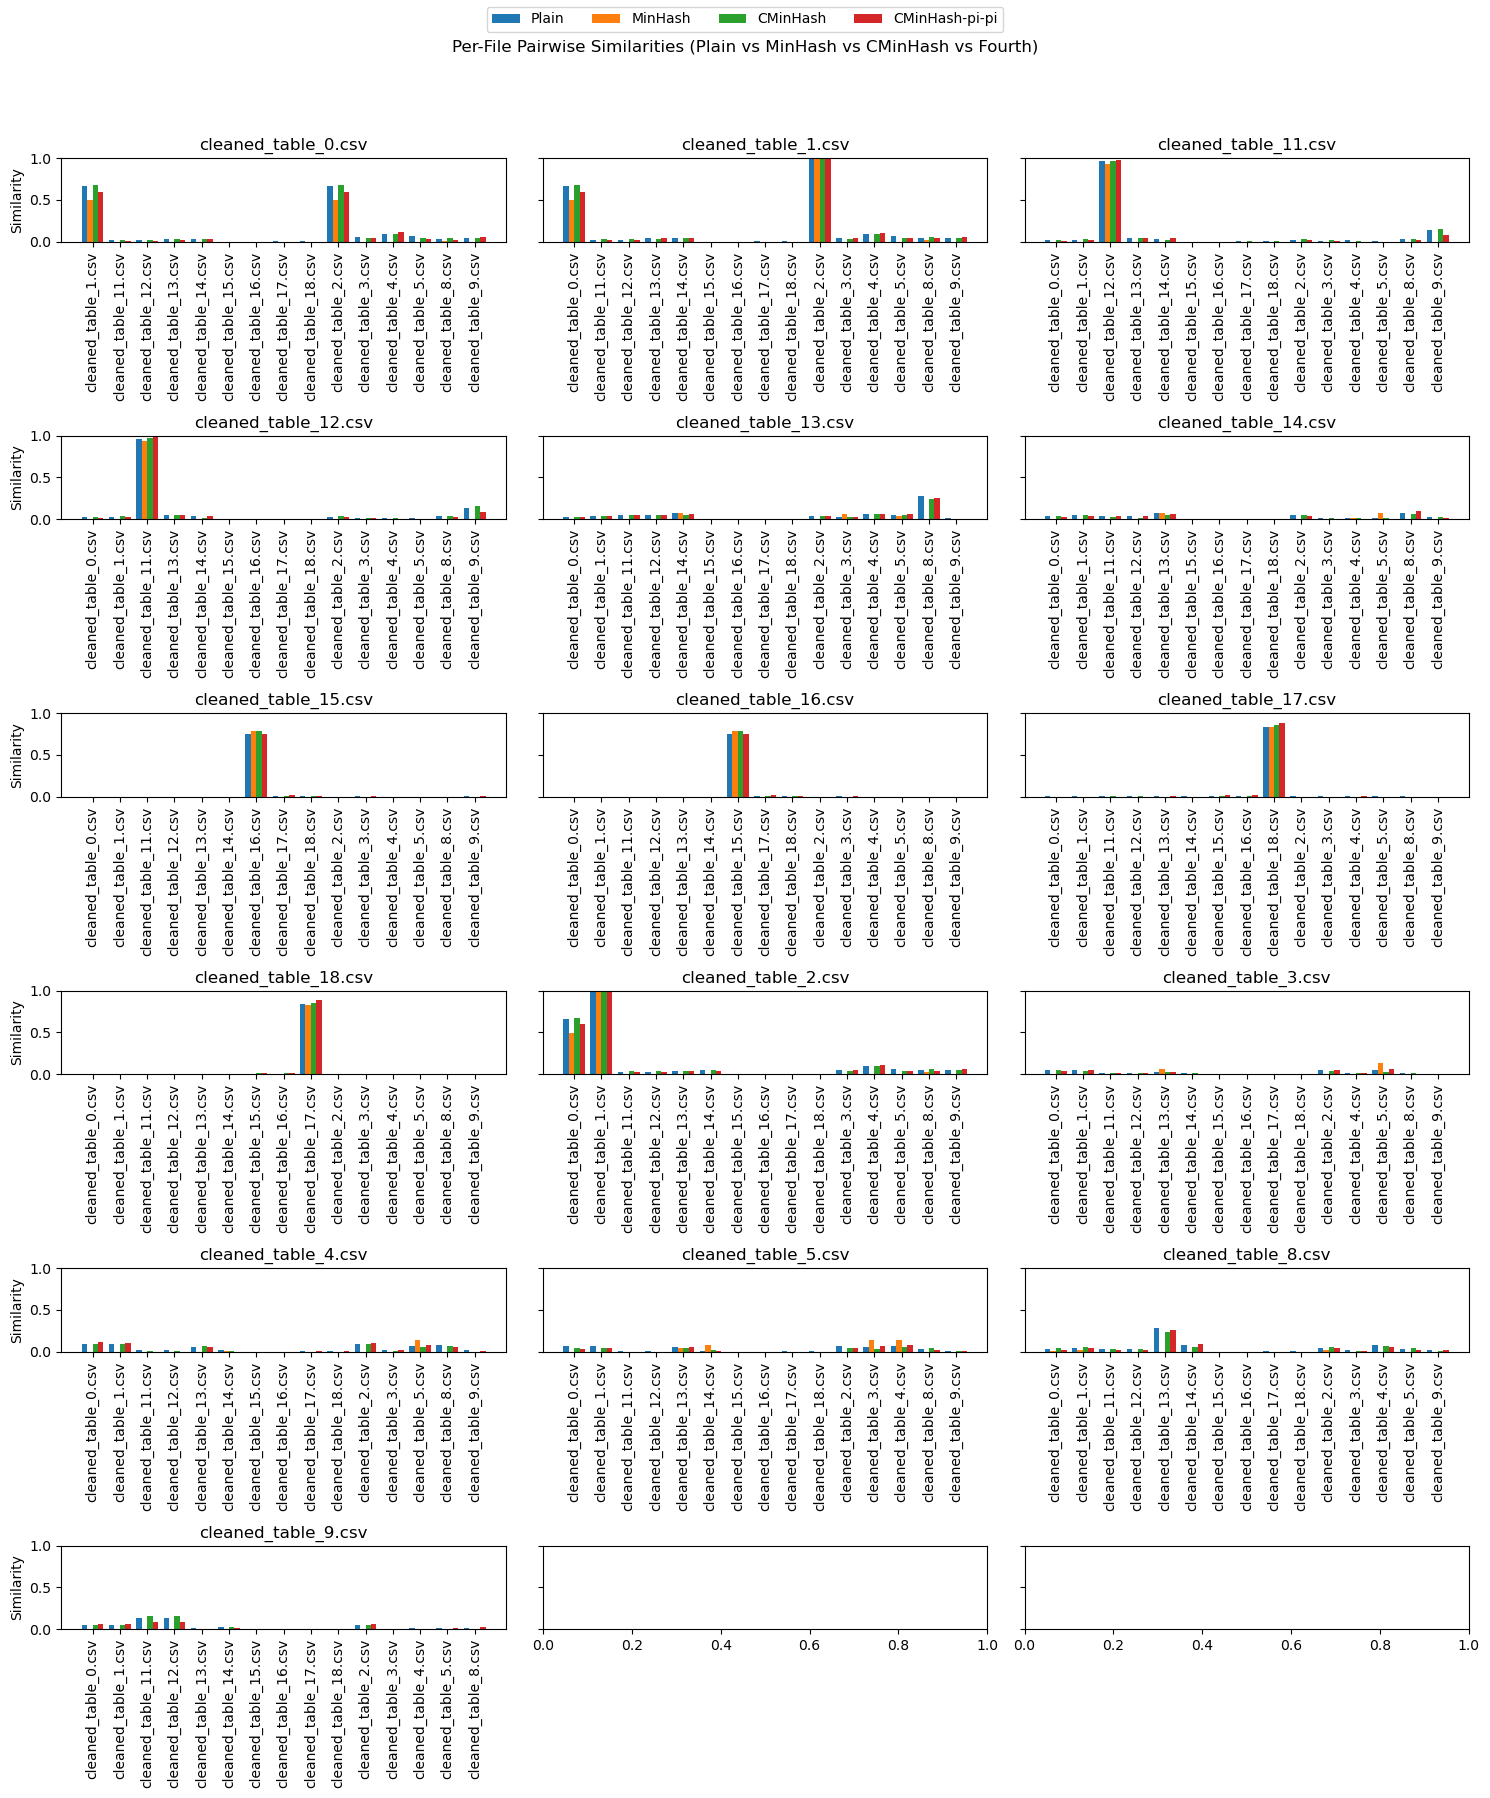

In [11]:
import numpy as np
import matplotlib.pyplot as plt

files = sorted(pdf.index)
n = len(files)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, max(6, rows * 3)), sharey=True)
axes = axes.flatten() if n > 1 else [axes]

bar_width = 0.2
offsets = (-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width)

for idx, anchor in enumerate(files):
    ax = axes[idx]
    others = [f for f in files if f != anchor]
    x = np.arange(len(others))

    y_plain = [plain_scores[anchor][o] for o in others]
    y_mh   = [hash_scores[anchor][o] for o in others]
    y_cmh  = [chash_scores[anchor][o] for o in others]
    y_cmhp = [chash_scores_pi[anchor][o] for o in others]

    ax.bar(x + offsets[0], y_plain, width=bar_width, label='Plain')
    ax.bar(x + offsets[1], y_mh,   width=bar_width, label='MinHash')
    ax.bar(x + offsets[2], y_cmh,  width=bar_width, label='CMinHash')
    ax.bar(x + offsets[3], y_cmhp, width=bar_width, label='CMinHash-pi-pi')

    ax.set_title(anchor)
    ax.set_xticks(x)
    ax.set_xticklabels(others, rotation=90)
    ax.set_ylim(0, 1)
    if idx % cols == 0:
        ax.set_ylabel('Similarity')


# One legend for all subplots (same as before)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)

fig.suptitle('Per-File Pairwise Similarities (Plain vs MinHash vs CMinHash vs Fourth)', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Task: For each table, find the top-5 most similar columns across all tables using Jaccard similarity of 8-shingles computed from each column’s flattened string. Return a tidy DataFrame with: source_file, source_col, match_file, match_col, jaccard, ranked by jaccard descending per source column.

Use already computed minhash_files and cminhash_files to build tidy DataFrames of pairwise Jaccard similarities (files × files) and a long-form table. Do not recompute signatures.

Code for LSH

In [13]:
from dataclasses import dataclass, field
from datasketch.hashfunc import sha1_hash32

@dataclass
class LSH:
    threshold: float = None
    b: int = 4
    r: int = 64
    num_perm: int = 256
    seed: int = 1
    hashfunc = sha1_hash32
    metadata = []

    def __post_init__(self):
        self.init_hashvalues()

    def init_hashvalues(self):
        self.hashvalues = np.empty(shape = (0, self.b * self.r), dtype=np.uint64)

    def add(self, minhash_list: List[ColStruct]):
        self.threshold = (1/self.b)**(1/self.r)
        print(f"approximate threshhold: {self.threshold}")
        minhash_digests = np.array([minhash.value.digest() for minhash in minhash_list], dtype=np.uint64)
        minhash_metadata = [(minhash.index, minhash.col_name) for minhash in minhash_list]
        self.metadata.extend(minhash_metadata)

        if (self.b * self.r != len(minhash_digests[0])):
            raise Exception("Invalid shape")

        self.hashvalues = np.append(self.hashvalues, minhash_digests, axis=0)

    def query(self, col: ColStruct) -> List[MinHash]:
        minhash_digests = np.array([col.value.digest()], dtype=np.uint64)
        if (self.b * self.r != len(minhash_digests[0])):
            raise Exception("Invalid shape")

        # VERY IMPORTANT WE SPLIT BY r
        hashvalues_split = np.split(self.hashvalues, self.b, axis=1)
        col_split = np.split(minhash_digests, self.b, axis=1)

        candidates = set()
        for i in range(self.b):
            w = np.where(np.all(hashvalues_split[i] == col_split[i], axis=1))
            if w is None or w is []:
                continue
            carr = w[0]
            candidates.add(tuple([self.metadata[j] for j in carr]))
        return candidates


In [15]:
import json
lsh = LSH()

cmh_ci_exp = pd.DataFrame(cminhash_cols.values())
cmh_ci_exp = np.array(cmh_ci_exp).reshape(-1)
cmh_ci_exp = [c for c in cmh_ci_exp if c is not None]

lsh.add(cmh_ci_exp)

outs = {}

# For each table, print out all columns that are at least 97% similar
for i in range(len(cmh_ci_exp)):
    qr = lsh.query(cmh_ci_exp[i])
    if len(qr) > 1:
        print(cmh_ci_exp[i])
        outs[str(cmh_ci_exp[i])] = str(qr)
        print(qr)
        print()

json.dump(outs, open("./outputs/CMinHash_LSH_similar_rows_copy.json", "w"))


approximate threshhold: 0.9785720620877001
ColStruct(index=('cleaned_table_0.csv', 1), col_name='Quality Indicator', value=<__main__.CMinHashTest object at 0x000002951C08E2C0>)
{((('cleaned_table_0.csv', 1), 'Quality Indicator'), (('cleaned_table_0.csv', 17), 'Quality Indicator.1'), (('cleaned_table_0.csv', 28), 'Quality Indicator.2'), (('cleaned_table_0.csv', 40), 'Quality Indicator.3'), (('cleaned_table_1.csv', 1), 'Quality Indicator'), (('cleaned_table_1.csv', 5), 'Quality Indicator.1'), (('cleaned_table_1.csv', 32), 'Quality Indicator.3'), (('cleaned_table_1.csv', 38), 'Quality Indicator.4'), (('cleaned_table_1.csv', 41), 'Quality Indicator.5'), (('cleaned_table_1.csv', 45), 'Quality Indicator.6'), (('cleaned_table_1.csv', 54), 'Quality Indicator.8'), (('cleaned_table_1.csv', 62), 'Quality Indicator.9'), (('cleaned_table_2.csv', 1), 'Quality Indicator'), (('cleaned_table_2.csv', 5), 'Quality Indicator.1'), (('cleaned_table_2.csv', 32), 'Quality Indicator.3'), (('cleaned_table_2.csv